In [9]:
import sys
import os 

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'src'))
print(f"Added to sys.path: {parent_dir}")

Added to sys.path: /home/vdakov/Desktop/thesis/msc-thesis-vasko


In [1]:
%ls

experiments-gp-prior.ipynb


In [ ]:
import models.encoders as encoders
from training_util import get_uniform_single_eval_pos_sampler, get_weighted_single_eval_pos_sampler, get_cosine_schedule_with_warmup
import train
from criterion.bar_distribution import BarDistribution, get_bucket_limits
from models import positional_encodings
from prior_generation import gp_prior
import torch

epochs = 50
batch_size =  128
warmup_epochs = 10
steps_per_epoch = 100
lr = 0.001
sequence_length = 100
emsize = 512
fuse_x_y = False
nlayers = 6
nhead = 4
nhid = 1024
dropout = 0.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_buckets = 100
min_y = -10
max_y = 10
num_features = 1
num_outputs = 100
prior_hyperparameters = {'num_features': num_features, 'num_outputs': num_outputs, 'device': device, 'kernel': "rbf", 'length_scale': 0.1}
input_normalization = False
aggregate_k_gradients=1
encoder_type = 'linear'  # 'linear' or 'mlp'
y_encoder_type = 'linear'
pos_encoder_type = 'none'  # 'sinus', 'learned', 'none'
scheduler = get_cosine_schedule_with_warmup

def get_encoder_generator(encoder):
        if encoder == 'linear':
            encoder_generator = encoders.LinearEncoder
        elif encoder == 'mlp':
            encoder_generator = encoders.MLPEncoder
        else:
            raise NotImplementedError(f'A {encoder} encoder is not valid.')
        return encoder_generator

encoder_generator = get_encoder_generator(encoder_type)
y_encoder_generator = get_encoder_generator(y_encoder_type)

if pos_encoder_type== 'sinus':
    pos_encoder_generator = positional_encodings.PositionalEncoding
elif pos_encoder_type == 'learned':
    pos_encoder_generator = positional_encodings.LearnedPositionalEncoding
else:
    pos_encoder_generator = positional_encodings.NoPositionalEncoding
    
permutation_invariant_max_eval_pos = sequence_length - 1
permutation_invariant_sampling = 'uniform'

if permutation_invariant_max_eval_pos is not None:
    if permutation_invariant_sampling == 'weighted':
        get_sampler = get_weighted_single_eval_pos_sampler
    elif permutation_invariant_sampling == 'uniform':
        get_sampler = get_uniform_single_eval_pos_sampler
    else:
        raise ValueError()
    
context_delimiter_generator = get_sampler(permutation_invariant_max_eval_pos)

transformer_configuration = (emsize, nhead, nhid, nlayers, dropout, num_features, num_outputs, input_normalization, y_encoder_generator, sequence_length, fuse_x_y) 
training_configuration = (epochs, steps_per_epoch, batch_size, sequence_length, lr, warmup_epochs, aggregate_k_gradients, scheduler)
generators = (encoder_generator, y_encoder_generator, pos_encoder_generator)
prior = gp_prior.GaussianProcessPriorGenerator()
print(prior.name)
criterion = BarDistribution(borders=get_bucket_limits(num_buckets, full_range=(min_y, max_y)))

Gaussian Process Prior


(200, 5, 1)


/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


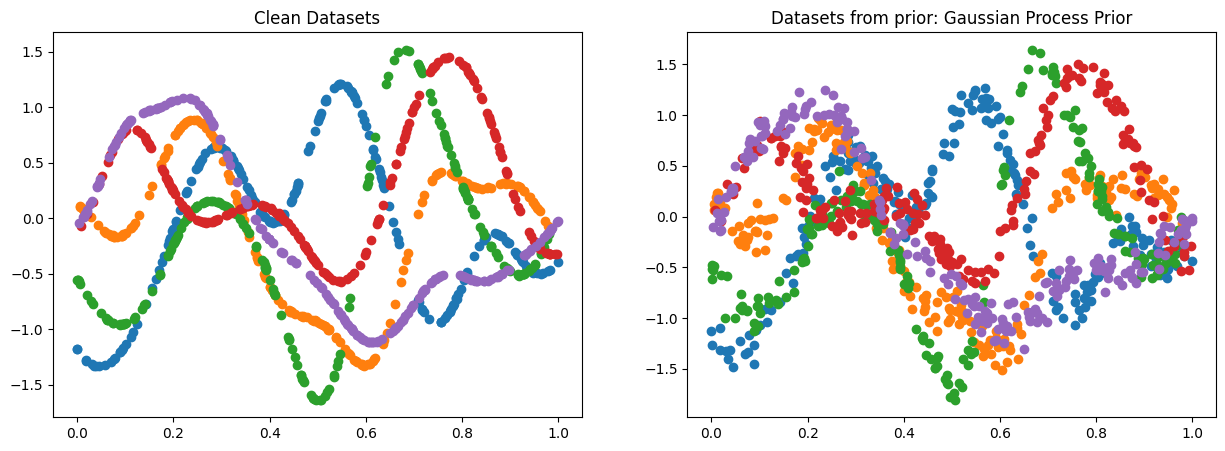

In [11]:
hyperparameters = { 'kernel': "rbf", 'length_scale': 0.1}
prior.visualize_datasets(number_of_datasets=5, num_points_per_dataset=200, num_features_per_dataset=1, device='cpu', **hyperparameters)

In [ ]:
# 6. Run Training
print(f"Starting training on {device}...")
losses, positional_losses, val_losses,  model = train.train(
    prior_dataloader=prior,
    criterion=criterion, # Passing the wrapper
    transformer_configuration=transformer_configuration,
    generators = generators,
    training_configuration=training_configuration,
    prior_hyperparameters=prior_hyperparameters,
    load_path=None,
    context_delimiter_generator = context_delimiter_generator,
    device=device,
    verbose=False,
    save_path=None,
)
# -7tPNnta8dSg6H33ZZcSz286MQp1OjhjeAk.01.0z1wd0yob

/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Starting training on cpu...
Using cpu:0 device
Dataset.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 128, 'seq_len': 100, 'num_features': 1, 'num_outputs': 100, 'device': 'cpu', 'kernel': 'rbf', 'length_scale': 0.1}, 'num_features': 1, 'num_outputs': 100}
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 128, 'seq_len': 100, 'num_features': 1, 'num_outputs': 100, 'device': 'cpu', 'kernel': 'rbf', 'length_scale': 0.1}, 'PriorDataset': <class 'prior_generation.prior_dataloader.get_dataloader.<locals>.PriorDataset'>, 'num_features': 1, 'num_outputs': 100, 'validation_set': ((tensor([[[0.7414],
         [0.9490],
         [0.3101],
         ...,
         [0.8126],
         [0.5366],
         [0.8317]],

        [[0.5319],
         [0.2580],
         [0.4379],
         ...,
         [0.8763],
         [0.9818],
         [0.7840]],

        [[0.3109],
         [0.2721],
         [0.6447],
         ...,
         [0

  0%|          | 0/50 [00:00<?, ?it/s]

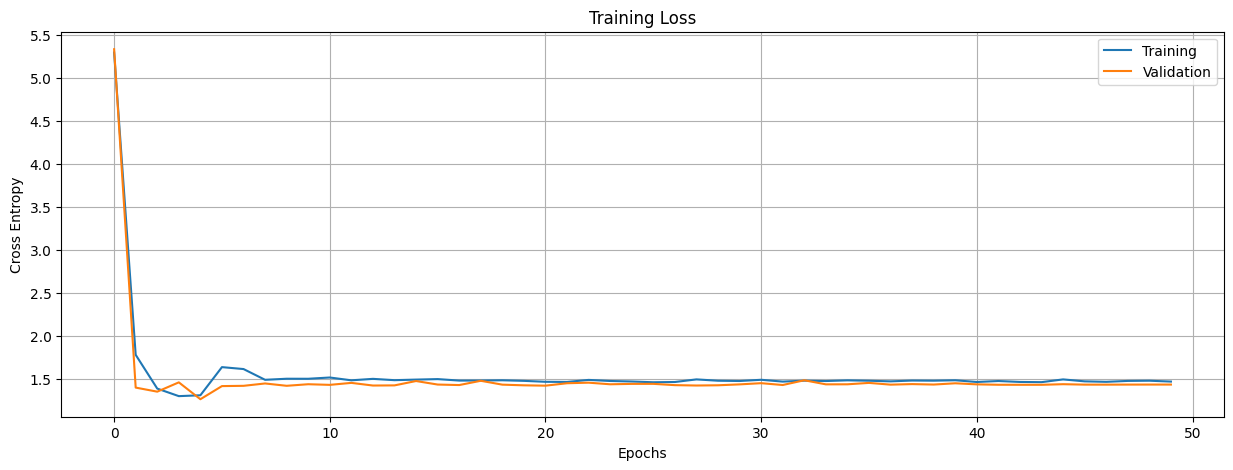

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.figure(figsize=(15, 5))
sns.lineplot(x=np.arange(0, len(losses)), y=np.array(losses), label="Training")
sns.lineplot(x=np.arange(0, len(losses)), y=np.array(val_losses), label="Validation")
plt.title("Training Loss")
plt.grid()
plt.legend()
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.show()

In [ ]:
train_X, train_Y, y_target = prior.get_datasets_from_prior(9, 100, 1, **hyperparameters)
print(train_X.shape)

torch.Size([100, 9, 1])


/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])
torch.Size([190, 1])


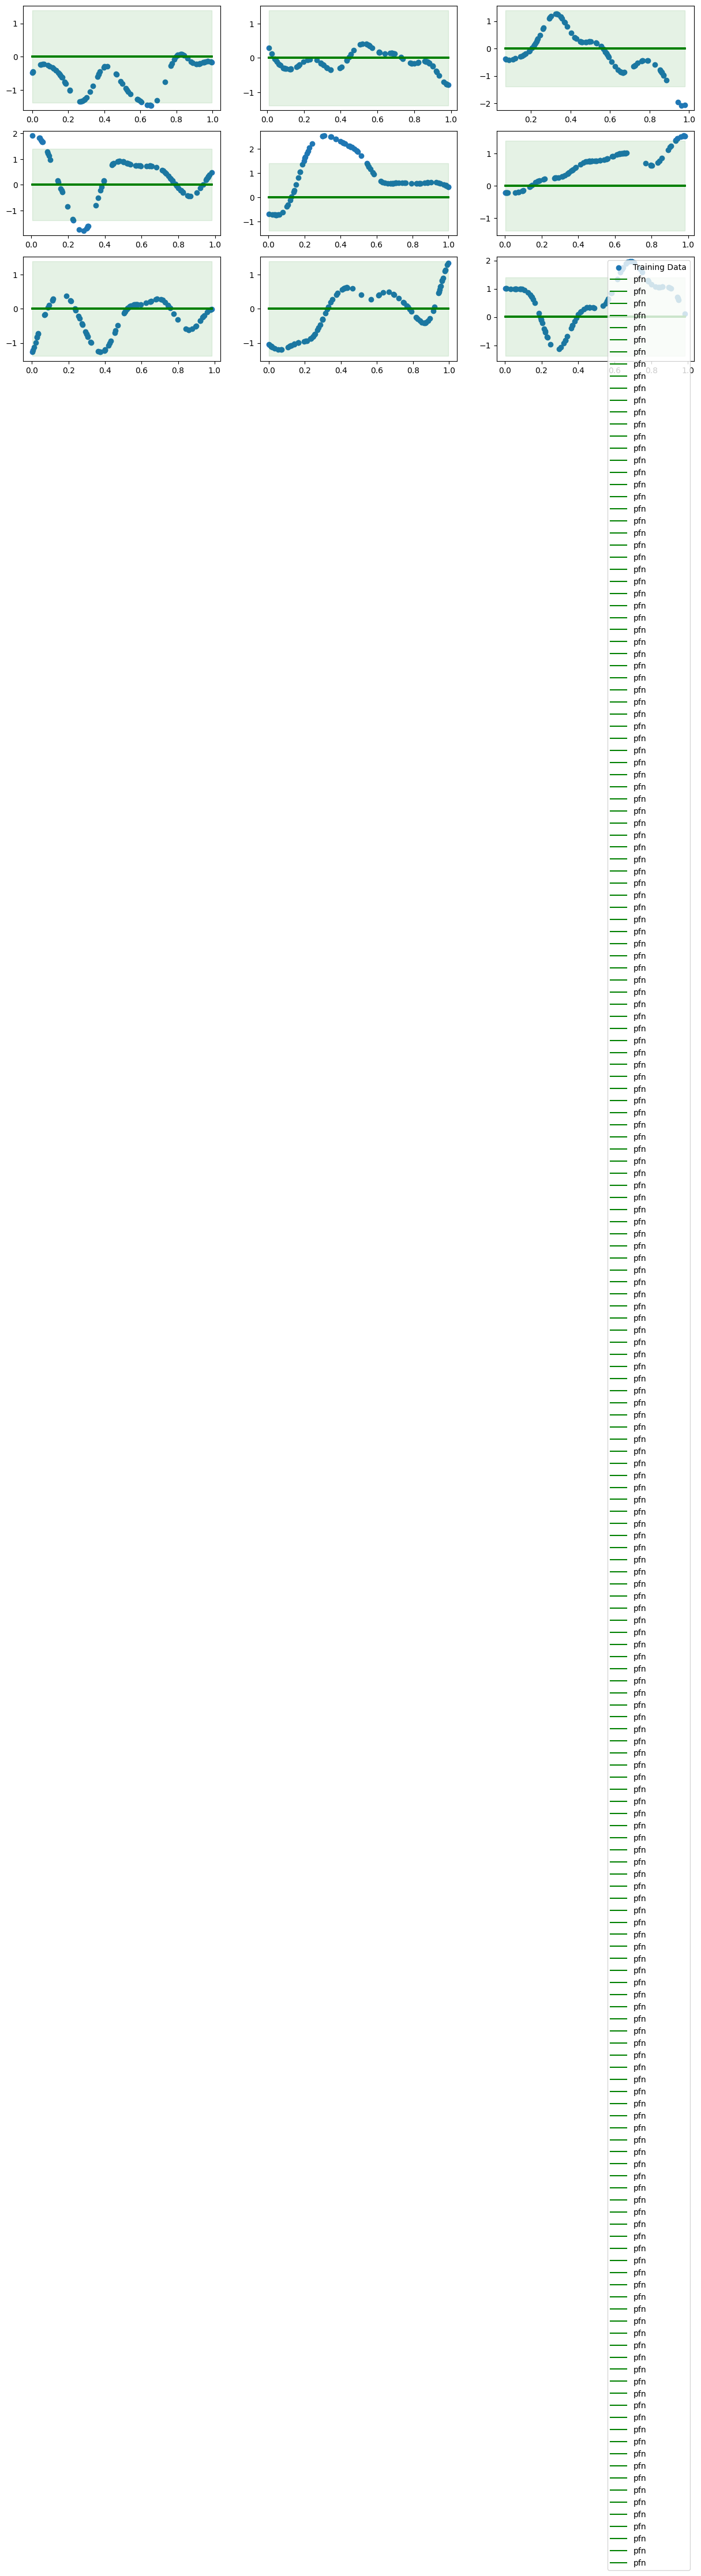

In [ ]:
num_training_points = 90

# Set up grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 8)) 
axes = axes.flatten()

for batch_index in range(9):
    ax = axes[batch_index] 
    train_x = train_X[:num_training_points, batch_index, :]
    train_y = train_Y[:num_training_points, batch_index]
    test_x = train_X[:, batch_index, :]
    with torch.no_grad():
        print((torch.cat((train_x, test_x)).shape))
        logits = model((torch.cat((train_x, test_x)), torch.cat((train_y, torch.zeros(len(test_x))))), context_pos=num_training_points - 1)

    pred_means = model.criterion.mean(logits)
    pred_confs = model.criterion.quantile(logits)
    # Plot scatter points for training data
    ax.scatter(train_x[..., 0].detach().numpy(), train_y.detach().numpy(), label="Training Data")

    # Plot model predictions
    order_test_x = test_x[..., 0].argsort()
    ax.plot(
        test_x[order_test_x, ..., 0].detach().numpy(),
        pred_means[order_test_x].detach().numpy(),
        color='green',
        label='pfn'
    )
    ax.fill_between(
        test_x[order_test_x, ..., 0].detach().numpy(),
        pred_confs[..., 0, 0][order_test_x].detach().numpy(),
        pred_confs[..., 0, 1][order_test_x].detach().numpy(),
        alpha=.1,
        color='green'
    )

plt.legend()
plt.show()
